# Gathering Insight from Kickstarter Data

_A machine learning project by Team Apple (Data Mining & Machine Learning, HEC Lausanne, Fall 2019)_

With the rise of the social web, a new practice known as crowdfunding has appeared, allowing individuals or companies to ask people around the world to invest in their projects. Multiple crowdfunding platforms have emerged since then. Kickstarter is certainly among the most popular ones (especially in the US). In 2019, the company received more than 4 billion USD for 445 thousand different projects in categories such as technology, art, media, ... The idea behind our machine learning project is to gather insight from Kickstarter’s data in order to determine the key factors to a crowdfunding campaign’s success or failure.

We will be using [this dataset](kaggle.com/kemical/kickstarter-projects) from Kaggle. It contains all Kickstarter projects until January 2018 (i.e. around 375’000 records). The data was collected directly from the Kickstarter website, probably by means of HTML parsing. For each record, the set provides several useful features such as the name of the project, its category, the launch date and deadline, the amount of money asked for, its state (failed, cancelled, suspended, succeeded or live), etc.

With this project, we would like to address two questions, namely:
* Which features can predict with accuracy the success or failure of a Kickstarter project?
* Which are the relevant features to determine the amount of money one should ask in order to improve the chances of success of a campaign?

Whenever applicable, we will also be mindful of how the situation looks like in Switzerland, since this could potentially be relevant for us, were we to start a crowdfunding campagin using the Kickstarter platform.

**Contents**

1. [Imports](#imports)
2. [Loading the data](#loading)
3. [Data cleaning](#cleaning)
4. [Exploratory data analysis (EDA)](#eda)
5. [Machine learning models](#ml)

## Imports<a name="imports"></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Loading the data<a name="loading"></a>

In [11]:
df = pd.read_csv("https://raw.githubusercontent.com/tbacha/DMML2019_Team_Apple/master/data/ks-projects-201801.csv")
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


## Data cleaning<a name="cleaning"></a>

For several reasons, the dataset in its raw state is only partially usable within the scope of this project. This is why it will undergo several cleaning operations.

### Data types

The first set of operations concerns data types. Two of them, namely `deadline` and `launched`, are time features which were falsely interpreted as floating-point numbers by pandas. To rectify this, we are turning them into datetime objects.

Other than that, all features have the correct type. Categorical features are considered as character strings, which is good enough for our purposes; there is no need to convert them into a `category` data type.

In [12]:
df["deadline"] = pd.to_datetime(df["deadline"])
df["launched"] = pd.to_datetime(df["launched"])
df.dtypes

ID                           int64
name                        object
category                    object
main_category               object
currency                    object
deadline            datetime64[ns]
goal                       float64
launched            datetime64[ns]
pledged                    float64
state                       object
backers                      int64
country                     object
usd pledged                float64
usd_pledged_real           float64
usd_goal_real              float64
dtype: object

### `state` feature

The second set of operations is related to project states. On the Kickstarter platform, they can take one of 6 possible values:

In [13]:
df["state"].unique()

array(['failed', 'canceled', 'successful', 'live', 'undefined',
       'suspended'], dtype=object)

For our project, we are addressing the criteria for success or failure. This means we have to somehow deal with other values of `state`. Since we are unable to determine "undefined" projects actually represent, they are simply removed. Furthermore, the information of "live" and "suspended" projects are subject to change after the capture of this dataset (in January of 2018). Therefore, these observations are also discarded (we are only interested in historical data that can be relied upon).

In [0]:
criteria = df["state"].isin(["failed", "successful", "canceled"])
df = df[criteria]

Since we would like to have only two classes to predict, we also have find a way to work with cancelled projects. There are around 700 projects marked as cancelled, but which actually reached their goal. For the sake of argument, we assume that these were succcessful; all others are considered as failures.

In [0]:
df.loc[(df["state"] == "canceled") & (df["usd_pledged_real"] >= df["usd_goal_real"]), "state"] = "successful"
df.loc[(df["state"] == "canceled") & (df["usd_pledged_real"] < df["usd_goal_real"]), "state"] = "failed"

Finally, to satisfy the prerequisites of some machine learning models, the "successful" and "failed" values are replaced by 1 and 0 respectively. 

In [16]:
df["state"] = df["state"].map({"successful": 1, "failed": 0})
df["state"].unique()

array([0, 1])

### Other features

When it comes to money features, the original dataset already came with normalized amounts in US dollars for `goal` and `pledged`. We are not taking into account currency exchange rate fluctuations over time, as this would needlessly raise the complexity of our task. Therefore, we have no need for those features anymore.

Moreover, the `usd pledged` feature seems to serve no apparent purpose, and some of its values seem faulty. If one looks at the second row of the dataframe (see [above](#loading)), the pledged amount should be 2421.0 USD, but this feature contains a value of 100.0. Since `usd_pledged_real` has all the information we need, we are removing `usd pledged`.

In [0]:
df = df.drop(["goal", "pledged", "usd pledged"], axis=1)

### Additional features

For analysis purposes, we are adding two new features:

* **Success rate**: this represents the percentage of the goal that was achieved;
* **Elapsed time**: the time that passed between the launch date and the deadline.

In [18]:
df["pct_reached"] = round(df["usd_pledged_real"] / df["usd_goal_real"], 2)
df["elapsed_time"] = df["deadline"] - df["launched"]
df[["pct_reached", "elapsed_time"]].head()

,pct_reached,elapsed_time
0,0.00,58 days 11:47:32
1,0.08,59 days 19:16:03
2,0.00,44 days 23:39:10
3,0.00,29 days 20:35:49
4,0.07,55 days 15:24:57


### Noisy values

In the search for noisy values, we find that there are 201 projects which somehow managed to raise money without the support of any backers. This also revealed a noisy value for `country` (N,0"). Since those records seem to be corrupted, we are removing them.

In [19]:
criteria = (((df["backers"]==0) & (df["usd_pledged_real"] > 0) | (df["country"] == 'N,0"')))
df[criteria].head(2)

,ID,name,category,main_category,currency,deadline,launched,state,backers,country,usd_pledged_real,usd_goal_real,pct_reached,elapsed_time
2457,1012744036,An Oratorio for our Time - Last Stop Cafe,Music,Music,USD,2016-05-26,2016-04-26 19:46:26,1,0,"N,0""",5170.0,5000.0,1.03,29 days 04:13:34
4338,1022254171,Help OrphanSporks Record Our Fourth Album!,Music,Music,USD,2016-05-14,2016-04-11 07:20:59,0,0,"N,0""",1375.0,2500.0,0.55,32 days 16:39:01


In [0]:
df = df[~criteria]

We also find that there are 3 projects for which no name was entered. Since the values of the other features make sense, and since the role played by a project's name in its success is only marginal, we decide to keep those records.

In [21]:
df[pd.isnull(df).any(axis=1)]

,ID,name,category,main_category,currency,deadline,launched,state,backers,country,usd_pledged_real,usd_goal_real,pct_reached,elapsed_time
166851,1848699072,NaN,Narrative Film,Film & Video,USD,2012-02-29,2012-01-01 12:35:31,0,1,US,100.00,200000.00,0.00,58 days 11:24:29
307234,634871725,NaN,Video Games,Games,GBP,2013-01-06,2012-12-19 23:57:48,0,12,GB,316.05,3224.97,0.10,17 days 00:02:12
338931,796533179,NaN,Painting,Art,USD,2011-12-05,2011-11-06 23:55:55,0,5,US,220.00,35000.00,0.01,28 days 00:04:05


### Final cleaning

The index is updated in order to avoid further complications during the data analysis and machine learning processes (especially for the concatenation of dataframes).

In [22]:
df.reset_index(inplace=True, drop=True)
df.tail(1)

,ID,name,category,main_category,currency,deadline,launched,state,backers,country,usd_pledged_real,usd_goal_real,pct_reached,elapsed_time
370218,999988282,Nou Renmen Ayiti! We Love Haiti!,Performance Art,Art,USD,2011-08-16,2011-07-19 09:07:47,0,17,US,524.0,2000.0,0.26,27 days 14:52:13


In [23]:
df.shape

(370219, 14)

## Exploratory data analysis (EDA)<a name="eda"></a>

Our cleaned version of the dataset contains 370'219 records and 14 features.

**Note to Ahmad and Michalis**: most of the EDA commentary hasn't been written yet, but we are satisfied with the metrics we are tracking (at least for now).

The features we suspect to have the most impact on the success of projects are:
* `main_category`
* `country`
* `usd_goal_real`
* `launched`, `deadline` and `elapsed_time`

Therefore we will focus on these for the EDA. Also, since the number of backers can also be an indicator of the level of success, part of the EDA is dedicated to it.

The following graph gives us our base rates.

/usr/local/lib/python3.6/dist-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


Text(0, 0.5, '')

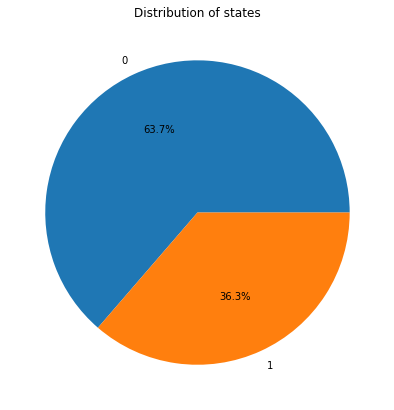

In [24]:
df_state = df[(df["state"] != "undefined")].groupby(["state"])["ID"].nunique()
ax = df_state.plot(kind="pie", figsize=(7,7), autopct="%1.1f%%")
ax.set_title("Distribution of states")
ax.set_ylabel("")

On average, failed and canceled projects tend to ask for a much higher amount of money than successful ones.

Text(0, 0.5, 'Goal (USD)')

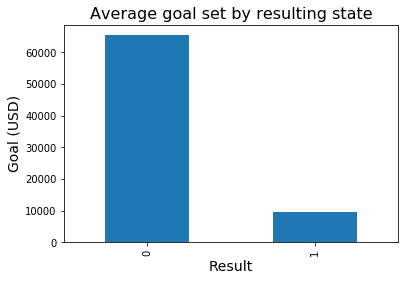

In [25]:
df_goal_state = df.groupby(["state"])["usd_goal_real"].mean()
ax = df_goal_state.plot(kind="bar")
ax.set_title("Average goal set by resulting state", size=16)
ax.set_xlabel("Result", size=14)
ax.set_ylabel("Goal (USD)", size=14)

The bulk of the data has reached 100% of its goal or less. The more successful projects can generate up to 2.5 times the amount they asked for.

There is an non-negligible number of outliers above the upper bound (about 18,000), the best ones having a ridiculously high percentage of success (max = 104,277.89 %). This is typically when the project owner asked only for a low amount of money, like 1 or 10 USD, and then met with tremendous success.

Text(0, 0.5, '% Success')

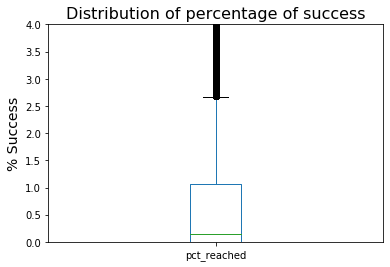

In [26]:
ax = df["pct_reached"].plot(kind="box", ylim=(0,4))
ax.set_title("Distribution of percentage of success", size=16)
ax.set_ylabel("% Success", size=14)

In [27]:
df["pct_reached"].sort_values().tail(10)

160805     16970.86
14937      22603.00
284515     23036.07
361002     24675.00
279115     27588.23
79574      32843.00
74607      41535.01
352689     55266.57
181965     68764.10
360966    104277.89
Name: pct_reached, dtype: float64

In [28]:
df[df["pct_reached"] > 2.7].shape[0]

17496

### Main categories

Close to a third of all projects are either related to the movie or the music industry.

Text(0, 0.5, 'Category')

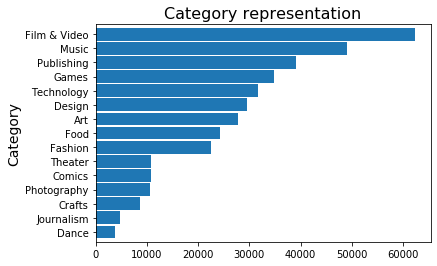

In [29]:
df_main_cat = df.groupby(["main_category"])["ID"].nunique().sort_values(ascending=True)
ax = df_main_cat.plot(kind="barh", x="main_category", width=0.9)
ax.set_title("Category representation", size=16)
ax.set_ylabel("Category", size=14)

In [30]:
print("Percentage of projects in the film and music industries:", (df_main_cat.iloc[-1] + df_main_cat.iloc[-2]) / df.shape[0] * 100)

Percentage of projects in the film and music industries: 30.075982053865413


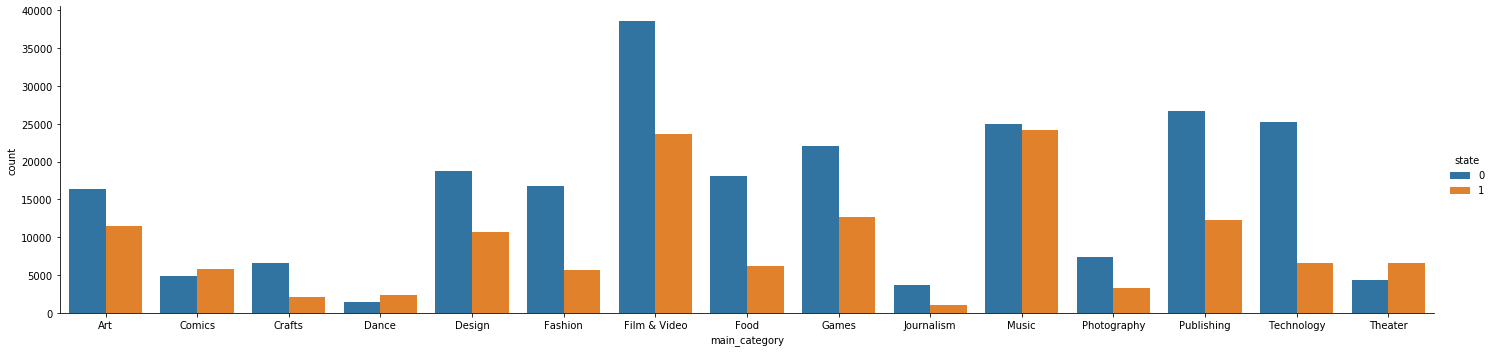

In [31]:
df_ordered_cat = df.sort_values(by=["main_category"])
ax = sns.catplot(kind="count", data=df_ordered_cat, x="main_category", hue="state", height=5, aspect=4)

Text(0, 0.5, 'Category')

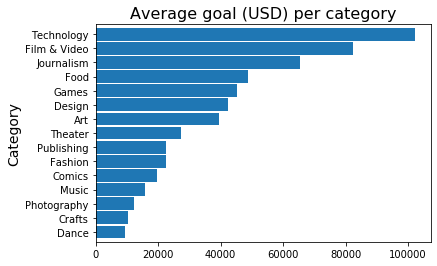

In [32]:
df_avg_goal = df.groupby(["main_category"])["usd_goal_real"].mean().sort_values(ascending=True)
ax = df_avg_goal.plot(kind="barh", width=0.9)
ax.set_title("Average goal (USD) per category", size=16)
ax.set_ylabel("Category", size=14)

### Countries

Non surprisingly, Kickstarter being first and foremost an English-speaking platform, the top 3 most represented countries are the US (by a large margin), the UK and Canada. Then come German and French countries.

Text(0, 0.5, '')

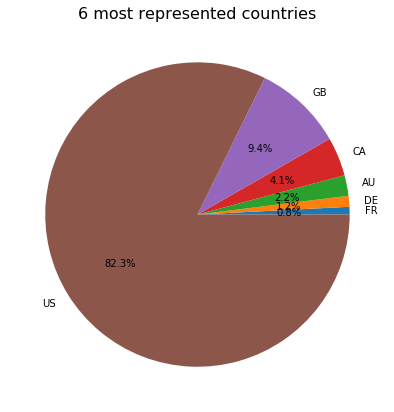

In [33]:
df_country = df.groupby(["country"])["ID"].count().sort_values()
ax = df_country.tail(6).plot(kind="pie", figsize=(7,7), autopct="%1.1f%%")
ax.set_title("6 most represented countries", size=16)
ax.set_ylabel("")

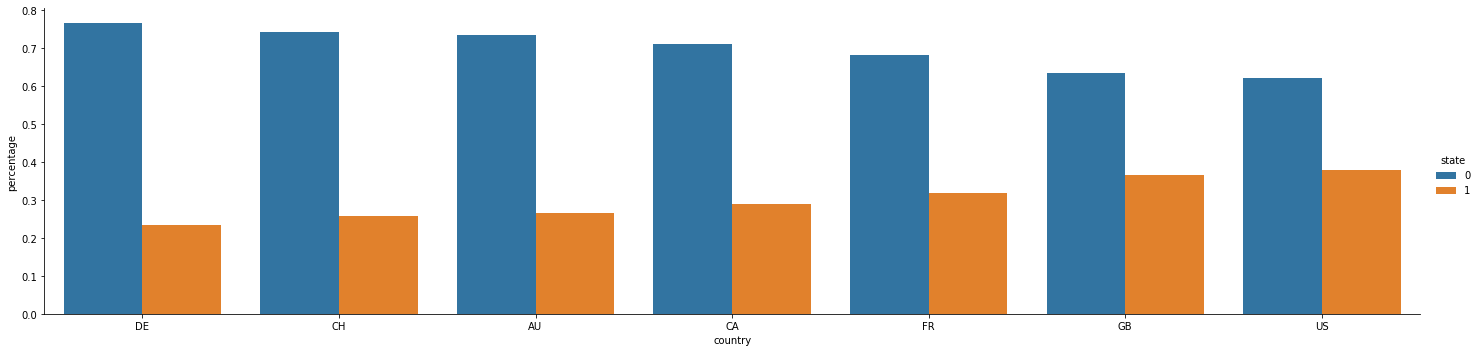

In [34]:
df_selected_countries = df[(df["country"].isin(["US", "GB", "CA", "AU", "DE", "FR", "CH"]))]
df_new = df_selected_countries.groupby(['country'])['state'].value_counts(normalize=True).rename('percentage').reset_index().sort_values('percentage', ascending=False)
ax = sns.catplot(kind="bar", data=df_new, x="country", y="percentage", hue="state", height=5, aspect=4)

Text(0.5, 0, 'Country')

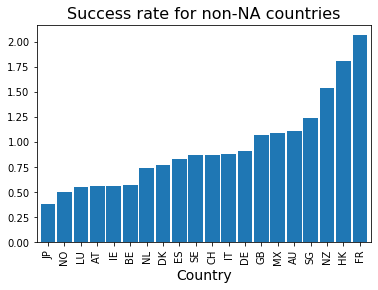

In [35]:
df_without_na = df[(~df["country"].isin(["US", "CA"]))].groupby(["country"])["pct_reached"].mean().sort_values()
df_without_na
ax = df_without_na.plot(kind="bar", width=0.9)
ax.set_title("Success rate for non-NA countries", size=16)
ax.set_xlabel("Country", size=14)

Most successful categories in Switzerland? How much money do they ask for on average?

In [36]:
df_switzerland = df[(df["country"] == "CH") & (df["state"] == 1)].groupby(["main_category"])[["ID", "usd_goal_real"]].agg({"ID":"count", "usd_goal_real":"mean"}).sort_values(by="ID", ascending=False)
df_switzerland

,ID,usd_goal_real
main_category,,
Design,53,35231.027925
Technology,37,27529.069730
Fashion,20,18541.223000
Games,18,15451.385556
Art,15,2548.498000
Music,12,5438.137500
Film & Video,10,6591.980000
Food,7,15925.568571
Crafts,5,18074.582000


### Backers
Analyse des backers selon plusieurs paramètre:</br>


1.   Quantité de bakers selon les statuts finaux (mean, max, min, median, mode)
2.   Quantité de bakers selon le type de projet (mean, max, min, median, mode)
3.   Quantité de bakers selon le pays (mean, max, min, median, mode)
4.   etc....




## Value of Bakers depending of the final state

as we can see below, the numbers of backers is pretty random and the spread is really big. 
The number of outliers seem to be really big with a mean at 263, a median at 71 and a mode at 19.


In [37]:
df.groupby(['state'])['backers'].agg(['mean','min','max','median',('mode',lambda x: x.mode()[0])])

,mean,min,max,median,mode
state,,,,,
0,17.514853,0,9326,3,0
1,263.704277,1,219382,71,19


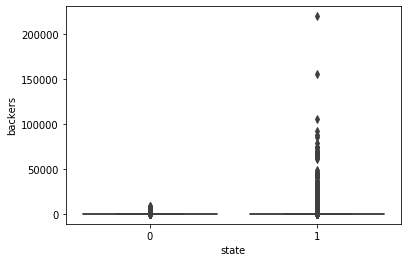

In [38]:
ax = sns.boxplot(x='state', y='backers', data=df)

As we thought the spread is super huge and the number of outliers is super huge too. Then we will represente in the result of the logarithme of those value

## Bakers selon la main_category


In [39]:
df.groupby(['main_category'])['backers'].agg(['mean','min','max','median', ('mode',lambda x: x.mode()[0])])

,mean,min,max,median,mode
main_category,,,,,
Art,42.378925,0,22834,10,0
Comics,135.629198,0,14952,40,0
Crafts,27.629258,0,12705,3,0
Dance,43.097430,0,4133,27,0
Design,241.609948,0,154926,29,0
Fashion,61.903987,0,15129,5,0
Film & Video,67.325804,0,91585,12,0
Food,54.408317,0,13116,6,0
Games,325.597753,0,219382,30,0


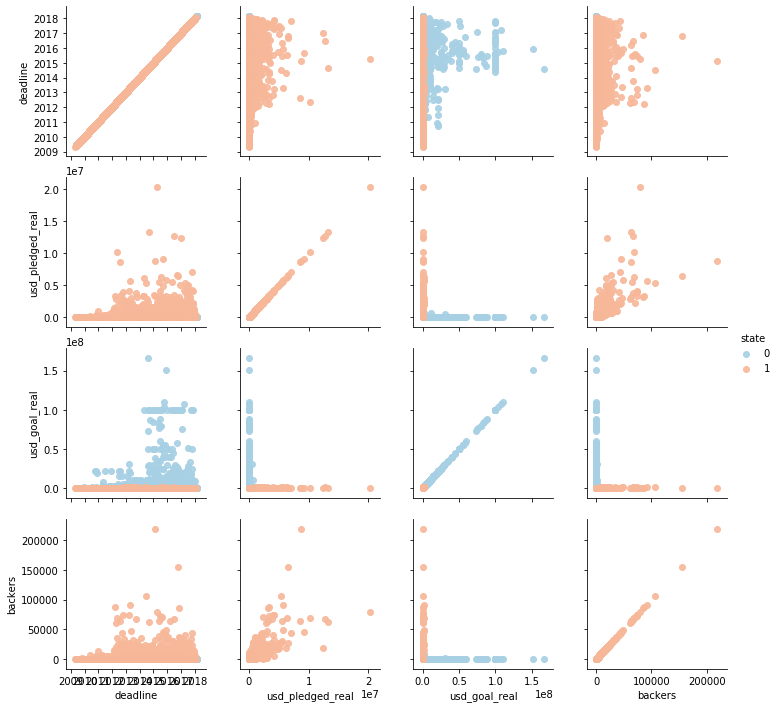

In [40]:
g = sns.PairGrid(df, vars=['deadline', 'usd_pledged_real', 'usd_goal_real', 'backers'],
                 hue='state', palette='RdBu_r')
g.map(plt.scatter, alpha=0.9)
g.add_legend();

In [41]:
df[df['state']==1]['usd_goal_real'].max()

2015608.88

The relation between the backers and the pledge are realy close.
One other thing, we could we focus on the goal less than 2'015'608.88

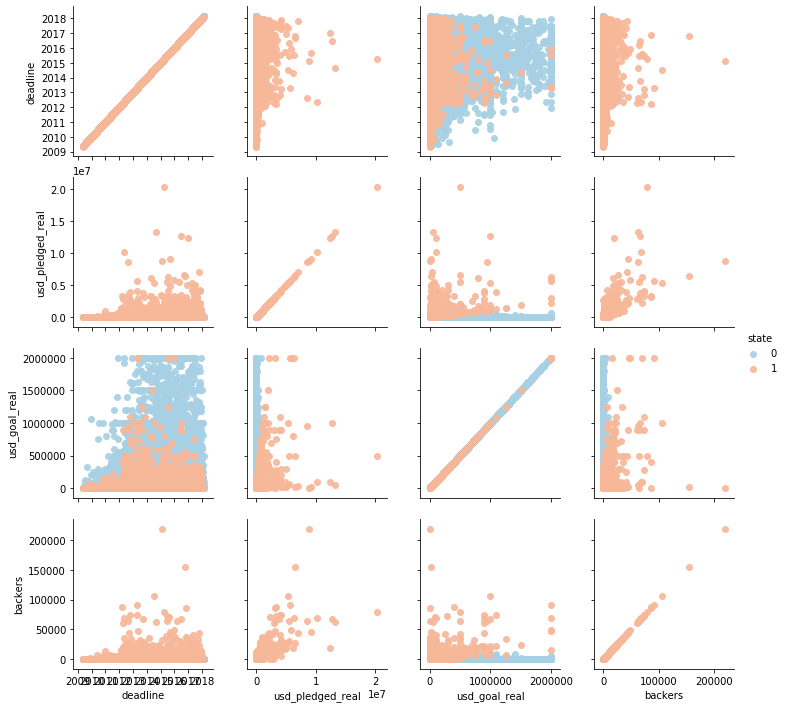

In [0]:
g = sns.PairGrid(df[df["usd_goal_real"]<2015608.88], vars=['deadline', 'usd_pledged_real', 'usd_goal_real', 'backers'],
                 hue='state', palette='RdBu_r')
g.map(plt.scatter, alpha=0.9)
g.add_legend();

## Machine learning models<a name="ml"></a>

 The classes to be predicted are either **1** (= successful) or **0** (= failed).
 
 As a reminder, the base rates are 36.3 and 63.7% respectively.
 
 We start our research using the first model for classification that we've seen in the course, logistic regression. We will experiment with other classification models to find the most accurate ones.

### Imports

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier

### Logistic Regression

First, to see if our dataset is coherent, we create and test a model to see how accurate the goal and the amount of money pledged are to predict the success or failure. If the dataset is coherent, this number should be very close to 100% and indeed, we reach near-perfection.

In [0]:
X = df[["usd_goal_real", "usd_pledged_real"]]
y = df["state"]
X.head()

,usd_goal_real,usd_pledged_real
0,1533.95,0.0
1,30000.00,2421.0
2,45000.00,220.0
3,5000.00,1.0
4,19500.00,1283.0


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
LR = LogisticRegressionCV(solver='lbfgs', cv=5, max_iter=1000)
LR.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=1000, multi_class='warn', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [0]:
LR.score(X_test, y_test)

0.9988250229593215

Moving beyond the obvious, we start including other features such as the category and the country. We remove the amount pledged, since this is not a variable that the project creater has direct control over. Since they are categorical data, we need to use a one-hot encoder so that the regression model can work with it.

In [0]:
X = df[["usd_goal_real"]]
one_hot = OneHotEncoder(categories="auto")
cat_to_onehot = one_hot.fit_transform(df[["main_category", "country"]]).toarray()
cat_to_onehot = pd.DataFrame(cat_to_onehot)
X = pd.concat((X, cat_to_onehot), axis=1)
X.head()

,usd_goal_real,0,1,2,3,4,5,6,7,8,...,27,28,29,30,31,32,33,34,35,36
0,1533.95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,30000.00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,45000.00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,5000.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,19500.00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Sadly, the accuracy is no better than our majority class' base rate. We need to find another mix of features, and try other models.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
LR.fit(X_train, y_train)
LR.score(X_test, y_test)

0.637310247960672

In [0]:
classification_report(y_test, LR.predict(X_test), output_dict=True)

{'0': {'precision': 0.6397564738751511,
  'recall': 0.980027254918661,
  'f1-score': 0.77415122742984,
  'support': 46964},
 '1': {'precision': 0.5535459305092812,
  'recall': 0.04294682422451994,
  'f1-score': 0.07970939995202357,
  'support': 27080},
 'accuracy': 0.637310247960672,
 'macro avg': {'precision': 0.5966512021922161,
  'recall': 0.5114870395715905,
  'f1-score': 0.42693031369093176,
  'support': 74044},
 'weighted avg': {'precision': 0.6082268223929546,
  'recall': 0.637310247960672,
  'f1-score': 0.5201740694143456,
  'support': 74044}}

### KNN

In [0]:
scores = []
kMax=0
for k in range(1, 100, 1):
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train, y_train)
    scores.append(clf.score(X_test, y_test))
    if clf.score(X_test, y_test) >= max(scores):
      kMax = k
plt.plot(range(1, 100, 1), scores)
plt.ylabel('accuracy', fontsize=15)
plt.xlabel('$k (knn2)$', fontsize=15)
print("kMax: ",kMax)

### Decision trees and random forests

### Neural networks